In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import CubicSpline

In [2]:
default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-8, 1e-8],
    'kappa': 2,
    'inner_period': 2*np.pi,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.5,
    'bisection_tol': 1e-12,
}

In [3]:
def integrate_one_cycle(sim, configs):
    time_step = configs['init_time_step']
    bisection_tol = configs['bisection_tol']
    target_mean_anomaly = configs['target_mean_anomaly']
    current_mean_anomaly = 0
    N_peri = 0
    counter = 0
    M = [0]
    times = [sim.t]
    
    while True:
        # Integrate by stepping one time
        time_now = sim.t + time_step
        sim.integrate(time_now)
        
        # Getting the actual current mean anomaly
        current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi

        # Correct mean anomaly
        if current_mean_anomaly - M[-1] < 0:
            N_peri += 1
            current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi 
            M.append(current_mean_anomaly)
            # print(f"Starting {N_peri}")
        else:
            M.append(current_mean_anomaly)

        # Store time
        times.append(sim.t)

        # Find the precise 16pi
        if current_mean_anomaly > target_mean_anomaly:
            target_time = bisection_sin_M(sim, target_mean_anomaly, times[-2], times[-1], M[-2], M[-1], bisection_tol)
            sim.integrate(target_time)
            return sim, target_time, times, M
            # return M, times, target_time


def bisection_sin_M(sim, target, a, b, Ma, Mb, tol=1e-9, doom_counts=10000):
    """
    Bisection method on sin M. The function terminates after a certain attempt.
    """    
    func = CubicSpline([a, b], [Ma, Mb], bc_type='natural')

    while True:
        half = (a + b)/2
        
        # If the target lies on the first half
        if (func(half) - target) > 0:
            a = a
            b = half
    
        # If the target lies on the second half
        if (func(half) - target) < 0:
            a = half
            b = b
    
        # print(np.abs(fa - fb))
        
        if np.abs(a - b) < 1e-8:
            # print(half, func(half))
            break

    return half

def wrap_angles(angles):
    for i, ang in enumerate(angles):
        while ang > np.pi or ang <= -np.pi:
            if ang < 0:
                ang += 2*np.pi
            elif ang > 0:
                ang -= 2*np.pi

        angles[i] = ang

    return angles

def wrap_angle(ang):
    while ang > np.pi or ang <= -np.pi:
        if ang < 0:
            ang += 2*np.pi
        elif ang > 0:
            ang -= 2*np.pi
    
    return ang

In [4]:
def init_simulation(theta, configs):
    inner_period = configs['inner_period']
    
    init_e = 10 ** np.array(theta[0:2], dtype=np.float64)
    init_M = theta[2]
    init_pomega = -theta[3]
    
    sim = rebound.Simulation()

    sim.add(m=1)
    sim.add(m=configs['planet_mass'][0], P=inner_period, e=init_e[0])
    sim.add(m=configs['planet_mass'][1], P=inner_period*configs['kappa'], pomega=init_pomega, M=init_M, e=init_e[1])
    
    return sim


def optimizing_function(theta, configs):
    init_theta = theta
    init_sim = init_simulation(init_theta, configs)

    final_sim, target_time, _, _ = integrate_one_cycle(init_sim, configs)
    final_sim.move_to_hel()
    

    final_theta = np.log10(final_sim.particles[1].e), np.log10(final_sim.particles[2].e), wrap_angle(final_sim.particles[2].M), wrap_angle(final_sim.particles[1].pomega - final_sim.particles[2].pomega)

    theta_diff = np.asarray(final_theta) - np.asarray(init_theta)
    # print(init_theta, final_theta)
    # print(theta_diff)

    diff = np.sum(theta_diff ** 2)
    # print(diff)
    return diff

    # return theta_diff

[-4.37434500e+00 -7.74599934e+00  1.94783142e-03 -8.34337329e-03] 4.815401917931032e-08
[-4.37410484e+00 -6.76912684e+00  2.03747699e-03 -8.86681111e-03] 4.959884472536773e-08
[-2.14493422e+00 -5.80486725e+00  1.87331881e-03 -8.46286902e-03] 4.935791936786203e-08
[-1.48764737e+00 -4.97704886e+00  1.81898985e-03 -9.72027801e-03] 4.938266536264457e-08
[-1.15527076e+00 -4.38046876e+00  2.47201007e-03 -1.20222064e-02] 4.9449721914379574e-08
[-1.06461020e+00 -3.73371392e+00  2.21405655e-03 -1.31972910e-02] 5.0008149806020874e-08
[-1.02304910e+00 -2.85290004e+00  2.25882982e-03 -1.36096283e-02] 5.4063481027515267e-08
[-0.8        -1.6675441   0.00260358 -0.05142067] 4.215309279452189e-08
[-8.00000000e-01 -1.76137297e+00  3.36623611e-03 -5.28533505e-05] 3.124692146155171e-08
[-8.00000000e-01 -1.76137297e+00  3.36623611e-03 -5.28533505e-05]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.9999), 'inner_period': 6.283185307179586, 'C': [], 'target

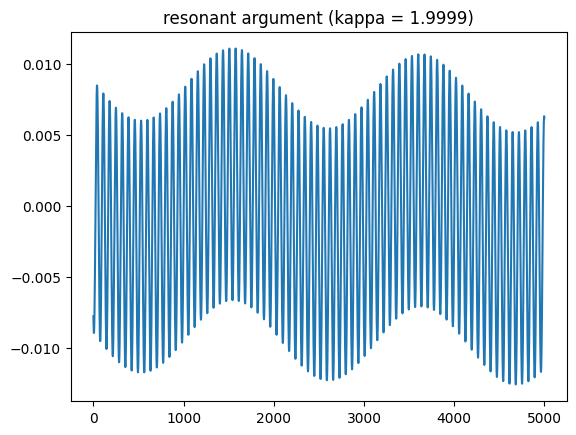

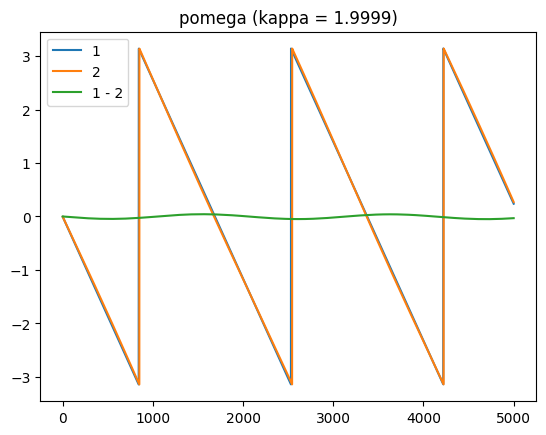

[-1.49698512e+00 -1.57268912e+00  1.06918101e-05 -1.02614056e-05] 6.317032725234858e-08
[-4.80847255e+00 -6.64906303e+00 -1.69859018e-06  1.97062724e-05] 3.084670613954114e-08
[-2.19178082e+00 -5.71457431e+00 -1.80723640e-06  2.26786869e-05] 3.1440937230376875e-08
[-2.23280662e+00 -4.69895967e+00 -1.89374968e-06  2.51620218e-05] 3.176209430887016e-08
[-1.16367244e+00 -4.26073736e+00 -1.90296239e-06  4.01858446e-05] 3.165649060422782e-08
[-1.02724183e+00 -4.06715346e+00 -1.66777356e-06  4.91598834e-05] 3.195749950577981e-08
[-1.00729550e+00 -3.82302779e+00 -1.77478429e-06  5.17671659e-05] 3.498564504536881e-08
[-8.00000000e-01 -1.67845095e+00 -1.60345576e-06  1.68325510e-04] 2.8931301282218596e-08
[-8.00000000e-01 -1.76299677e+00 -1.61078571e-06  1.68811895e-04] 1.914700876325924e-08
[-8.00000000e-01 -1.76299677e+00 -1.61078571e-06  1.68811895e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.99992), 'inner_period': 6.283185307179586, 

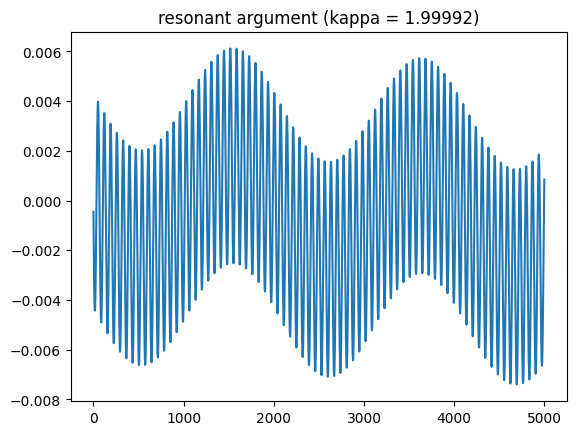

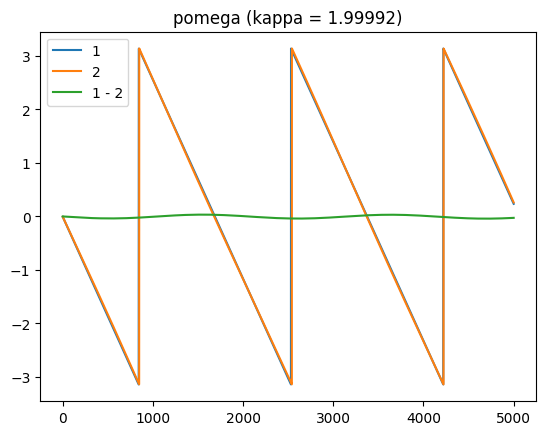

[-1.57142944e+00 -1.56718140e+00 -1.34704590e-04 -2.67089844e-04] 3.55325204529361e-08
[-5.24063965e+00 -6.51190351e+00  1.67552972e-04  6.95717268e-04] 1.8979006614454167e-08
[-2.12282547e+00 -5.58639717e+00  3.13074808e-04  9.46982101e-04] 1.7749758194560052e-08
[-2.14980416e+00 -4.58288061e+00  3.26418000e-04  9.98218843e-04] 1.787984400445539e-08
[-1.13726331e+00 -4.20789969e+00  4.01029756e-04  1.67575513e-03] 1.7815402326397178e-08
[-1.02113873e+00 -4.07548105e+00  4.42659175e-04  1.68452124e-03] 1.8041895741401487e-08
[-1.00645640e+00 -1.64794406e+00  6.10318780e-04  1.96643435e-03] 2.011741812537412e-08
[-8.00003616e-01 -1.70220818e+00  6.18863782e-04  2.24898811e-03] 1.6174927237010053e-08
[-8.00000941e-01 -1.76502633e+00  6.30776490e-04  2.32526338e-03] 1.0116148811216209e-08
[-8.00000941e-01 -1.76502633e+00  6.30776490e-04  2.32526338e-03]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.99994), 'inner_period': 6.28318530717958

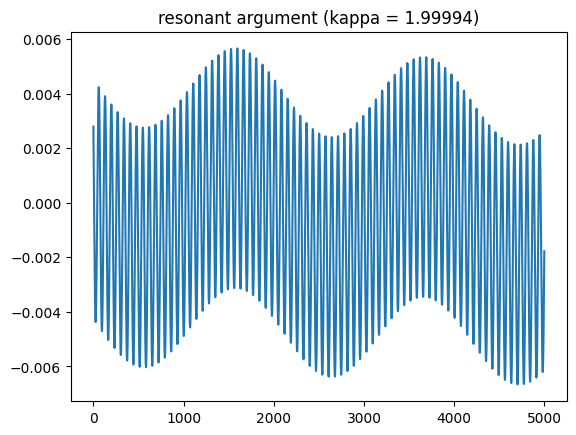

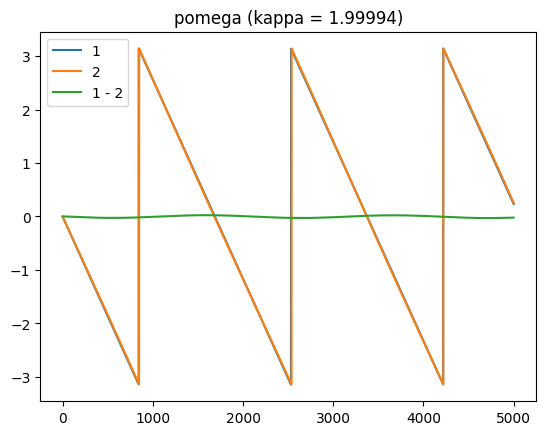

[-1.51026915e+00 -1.52675088e+00 -1.25986403e-04  3.43400419e-05] 1.5787406715597423e-08
[-1.58288817e+00 -1.52915506e+00 -1.25794163e-04  3.43626782e-05] 1.578240038426627e-08
[-1.59414828e+00 -1.56481264e+00 -1.25662487e-04  3.27848558e-05] 1.576430377057675e-08
[-1.53954504e+00 -4.55068030e+00 -1.93578881e-04  1.14726992e-05] 7.905193870488824e-09
[-1.15095858e+00 -3.98751489e+00 -1.90775609e-04  1.16674469e-05] 7.930577132679973e-09
[-1.02336454e+00 -3.81183740e+00 -1.81054723e-04  1.17129641e-05] 8.079172466322661e-09
[-8.00007476e-01 -1.09755860e+00  3.47891936e-04  3.19523044e-05] 6.760160221763437e-09
[-8.00001512e-01 -1.72514222e+00  3.48093332e-04  3.44798956e-05] 6.924283095805242e-09
[-8.00000412e-01 -1.76740879e+00  3.50489679e-04  3.54461220e-05] 2.5358980297121135e-09
[-8.00000412e-01 -1.76740879e+00  3.50489679e-04  3.54461220e-05]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.9999600000000002), 'inner_period': 6.283185

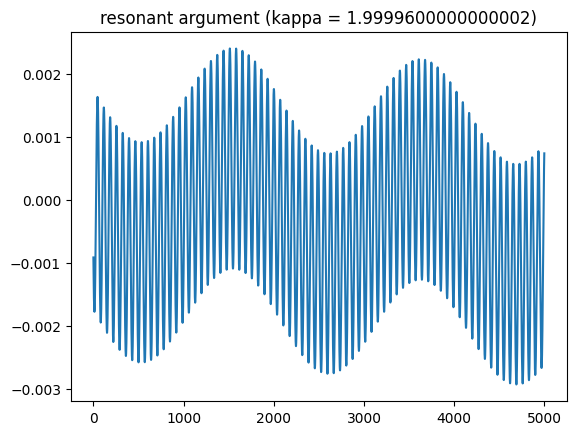

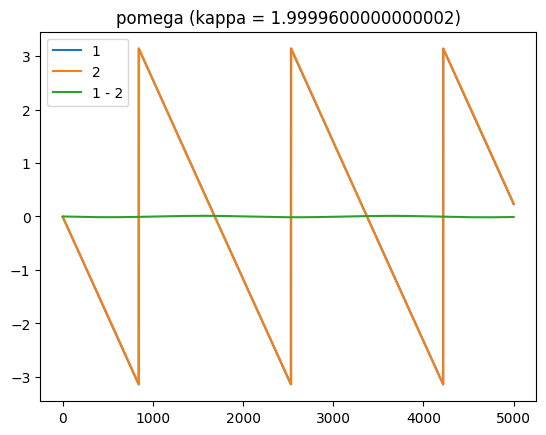

[-1.47620807e+00 -1.60804984e+00 -2.57053713e-07  1.16286427e-04] 3.947861688069254e-09
[-4.40749705e+00 -6.14593260e+00 -1.76132604e-07 -1.36964008e-05] 1.6637395753163029e-09
[-3.14614109e+00 -5.05645701e+00 -2.14558293e-07 -1.54412657e-05] 1.969461958208699e-09
[-1.58665962e+00 -4.22102273e+00 -2.40997519e-07 -1.43088876e-05] 1.976970699587089e-09
[-1.16588300e+00 -3.63886164e+00 -2.65037611e-07 -1.86696205e-05] 1.9916778073791476e-09
[-1.01936857e+00 -3.53707087e+00 -2.91848400e-07 -1.86812523e-05] 2.0629386237292958e-09
[-8.00000000e-01 -1.50507682e+00 -6.30583874e-07 -4.28928027e-05] 1.8204428610074943e-09
[-8.00000000e-01 -1.74704091e+00 -6.45108612e-07 -4.19171451e-05] 1.5818114685028993e-09
[-8.00000000e-01 -1.76953532e+00 -6.75431017e-07 -4.08770058e-05] 5.7241016420850993e-11
[-8.00000000e-01 -1.76953532e+00 -6.75431017e-07 -4.08770058e-05]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.99998), 'inner_period': 6.2831853071795

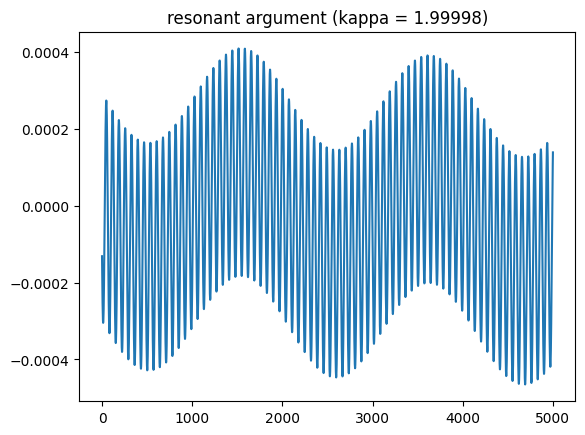

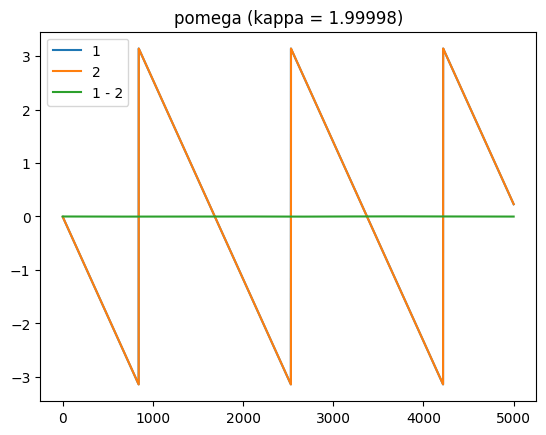

[-1.5 -1.5  0.   0. ] 4.4570641144987167e-29
[-1.5375 -1.5     0.      0.    ] 1.1537090738857298e-29
[-1.5375e+00 -1.5000e+00  0.0000e+00  2.5000e-04] 1.916374761679158e-15
[-8.00000000e-01 -1.76320741e+00  2.03492477e-03  2.79785734e-04] 3.328981566464208e-19
[-8.00000000e-01 -1.76730136e+00  2.00849259e-03  2.90944418e-04] 1.7803719865339006e-17
[-8.00000000e-01 -1.76712325e+00 -7.60568158e-04  5.49051500e-04] 1.2787777614990673e-15
[-8.00000000e-01 -1.76708923e+00 -7.01059750e-04  5.46413558e-04] 1.4132550970382002e-13
[-8.00000000e-01 -1.76750919e+00 -6.39460453e-04  5.73018332e-04] 1.4065118496021545e-11
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04] 1.2681751177486516e-09
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol':

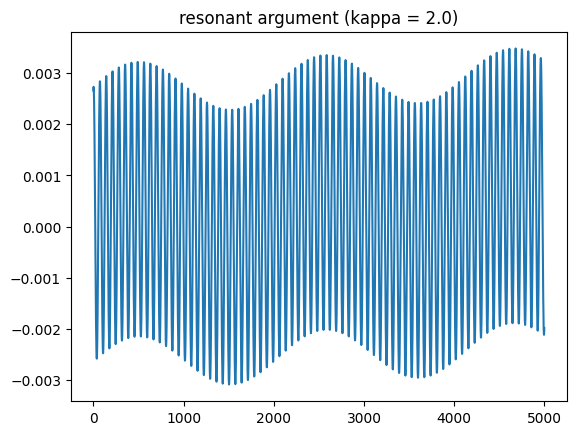

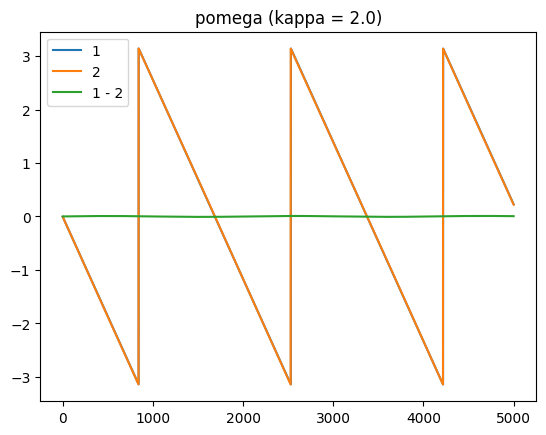

[-1.51390593e+00 -1.50319548e+00  6.31988049e-05 -3.69179249e-05] 3.94683162260322e-09
[-1.49595774e+00 -1.52816904e+00  6.28524978e-05 -3.69856583e-05] 3.9368462441594685e-09
[-8.05210379e-01 -5.47106347e+00  2.00727919e-04  6.64693852e-05] 1.955071509167888e-09
[-8.63082167e-01 -4.62924764e+00  2.11567739e-04  6.78287089e-05] 1.9712519250417403e-09
[-9.34027314e-01 -3.95498628e+00  2.15187305e-04  7.07805780e-05] 1.968225016736158e-09
[-9.91411457e-01 -3.76207645e+00  2.24498466e-04  7.04070918e-05] 1.8993076740159696e-09
[-1.00265402e+00 -3.90194279e+00  2.11071453e-04  6.84423683e-05] 1.2519491929918514e-09
[-9.18016293e-01 -2.27266549e+00  2.40255378e-03  1.21585463e-03] 1.472720513757875e-11
[-0.822152   -1.84529892  0.00237251  0.00256029] 1.4054987134104052e-13
[-0.822152   -1.84529892  0.00237251  0.00256029]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.00002), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly'

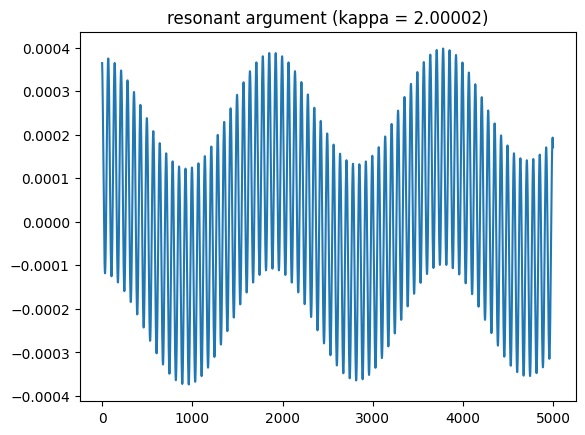

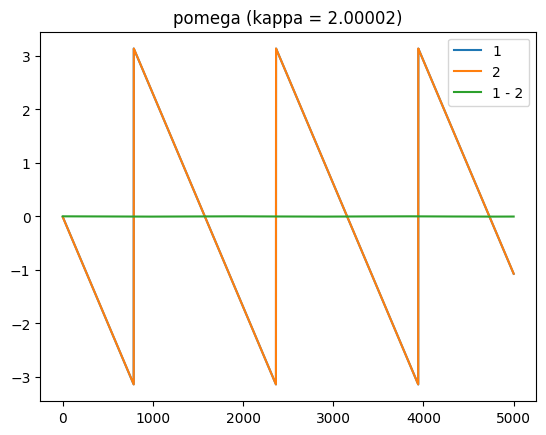

[-1.42472562e+00 -1.53651953e+00  1.25596784e-04  1.30766873e-04] 1.5774552153413006e-08
[-1.42461087e+00 -1.53688758e+00  1.25596748e-04  1.37266304e-04] 1.5774543198659118e-08
[-1.44835125e+00 -1.53896108e+00  1.25585951e-04  1.37268338e-04] 1.578725645248679e-08
[-8.00000000e-01 -4.76272372e+00  2.62997684e-04  4.73678953e-04] 7.890052415987353e-09
[-8.78992775e-01 -3.99326081e+00  2.73184545e-04  4.82262812e-04] 7.887980308394199e-09
[-9.93666996e-01 -4.08605975e+00  3.67632873e-04  4.90892113e-04] 7.743582544227538e-09
[-1.00185255e+00 -3.91388080e+00  3.84101289e-04  4.81765330e-04] 6.374903476756986e-09
[-1.00090891e+00 -3.64022277e+00  3.91277656e-04  3.96810392e-04] 6.484405773111361e-13
[-8.36770103e-01 -1.89870789e+00  2.57594058e-03 -1.46657633e-03] 3.632147347959399e-09
[-8.36770103e-01 -1.89870789e+00  2.57594058e-03 -1.46657633e-03]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0000400000000003), 'inner_period': 6.283185

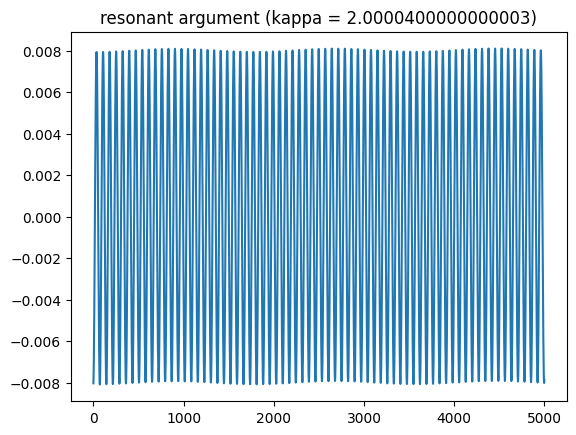

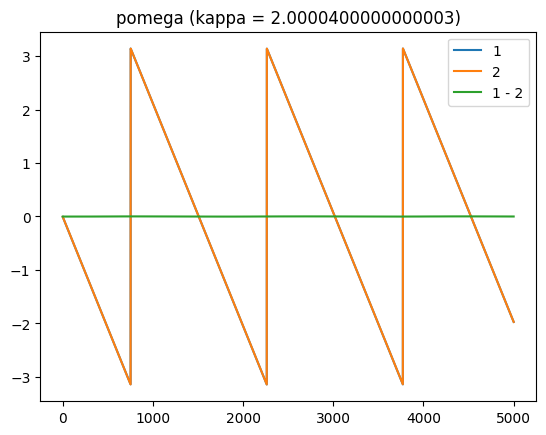

[-1.51757812e+00 -1.48476563e+00 -3.90625000e-05  5.85937500e-05] 3.552857364803776e-08
[-9.61347491e-01 -7.64376082e+00  1.06334927e-05  1.35075932e-05] 9.275983136203372e-09
[-9.94925427e-01 -7.32674908e+00  1.06634599e-05  1.37262523e-05] 1.2323160358080853e-08
[-1.00234095e+00 -6.76587942e+00  1.08818534e-05  1.45135621e-05] 1.5710394216635614e-08
[-1.00513205e+00 -6.52487878e+00  1.08751912e-05  1.51520061e-05] 1.676305037292414e-08
[-1.00524890e+00 -5.63667714e+00  1.19419610e-05  1.62827949e-05] 1.738821412114494e-08
[-1.00515428e+00 -4.81787760e+00  1.28889591e-05  1.66515872e-05] 1.544193366806434e-08
[-1.00503501e+00 -4.61347474e+00  1.36524045e-05  1.62502827e-05] 1.9579394899044767e-09
[-8.45224160e-01 -1.93108590e+00  7.58236534e-05  1.68991211e-04] 1.713884094828801e-12
[-8.45224160e-01 -1.93108590e+00  7.58236534e-05  1.68991211e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0000600000000004), 'inner_period': 6.28318

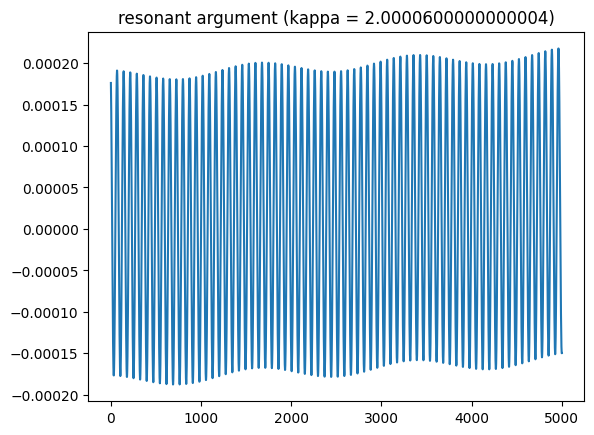

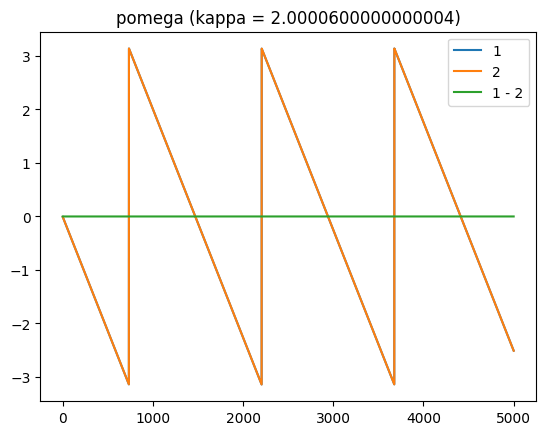

[-1.50102403e+00 -1.49776889e+00  2.51274050e-04 -1.42295954e-05] 6.315314983602552e-08
[-1.50033358e+00 -1.49770768e+00  2.51323310e-04 -1.42307804e-05] 6.311930236938044e-08
[-1.50062736e+00 -1.49761494e+00  2.51352753e-04 -1.49358294e-05] 6.312956483362005e-08
[-8.00000000e-01 -5.06456424e+00  5.75428241e-04 -5.56132886e-05] 3.157048230752525e-08
[-8.65279253e-01 -4.24461423e+00  6.09855387e-04 -5.79728122e-05] 3.156888761561048e-08
[-9.49620149e-01 -3.68570349e+00  6.53021243e-04 -5.88203424e-05] 3.1356679419573695e-08
[-1.00030295e+00 -3.92752119e+00  6.06711805e-04 -5.80002951e-05] 2.8524444330242268e-08
[-9.96540472e-01 -3.38570890e+00  5.43341117e-04 -7.64550282e-05] 8.569494881103503e-09
[-8.56322761e-01 -1.97563087e+00  6.21538793e-05  6.58115845e-05] 1.0833773487432954e-15
[-8.56322761e-01 -1.97563087e+00  6.21538793e-05  6.58115845e-05]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.00008), 'inner_period': 6.283185307179586,

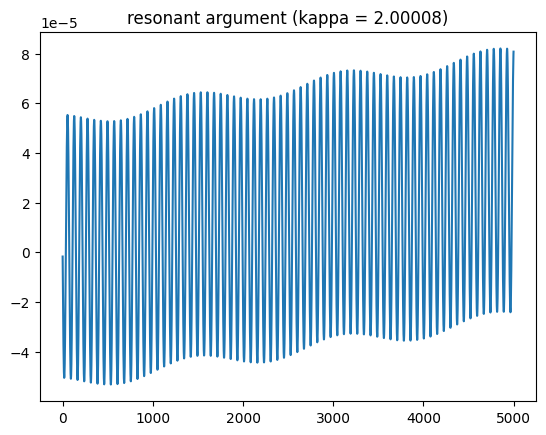

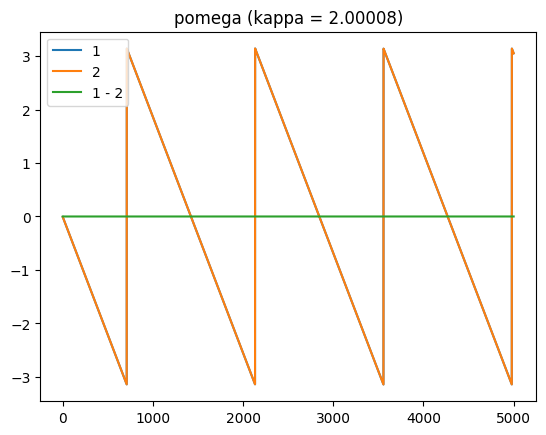

[-1.43645662e+00 -1.46770348e+00  3.14074457e-04  1.25976233e-04] 9.864276476695804e-08
[-1.43645662e+00 -1.54108865e+00  3.14074457e-04  1.25976233e-04] 9.864276476795142e-08
[-1.51784981e+00 -1.53647856e+00  3.14282829e-04  1.27007751e-04] 9.867619989999835e-08
[-8.00000000e-01 -5.15453790e+00  4.18699886e-04  2.90562514e-04] 4.932326553473063e-08
[-8.76920009e-01 -4.37886546e+00  4.38646369e-04  2.96731346e-04] 4.9323848165824484e-08
[-9.57590269e-01 -3.84599680e+00  4.76014372e-04  2.93153759e-04] 4.904527208631095e-08
[-1.00212322e+00 -4.17659708e+00  4.38662007e-04  2.89655468e-04] 4.5403073858176155e-08
[-1.00321806e+00 -4.01640291e+00  4.60223344e-04  2.96341788e-04] 1.7270746745233803e-08
[-8.67058444e-01 -2.02116151e+00 -3.98122601e-04 -4.21522720e-04] 5.7156561825884855e-15
[-8.67058444e-01 -2.02116151e+00 -3.98122601e-04 -4.21522720e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0001), 'inner_period': 6.283185307179586,

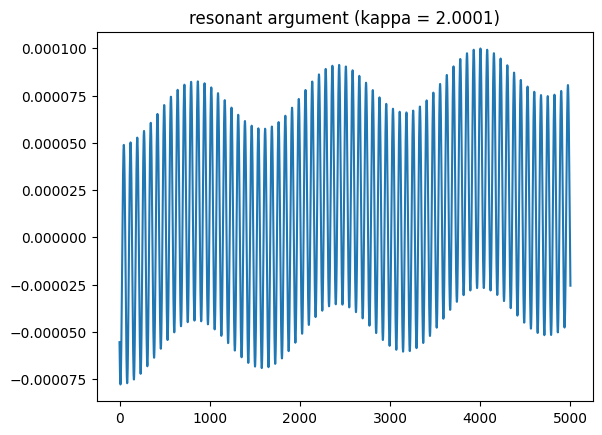

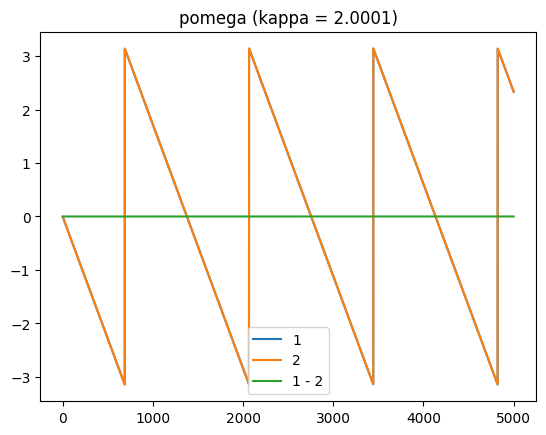

In [5]:
# Mass Continuation then Kappa

mass_cands = 10 ** np.arange(-12., -3., 1.)
kappa_cands = np.linspace(1.99990, 2.00010, 11)

bounds = [(-10, -0.8), (-10, -0.8), (-np.pi, np.pi), (-np.pi, np.pi)]

for j, kappa in enumerate(kappa_cands):
    init_theta = [-1.5, -1.5, 0, 0]
    
    for i, m in enumerate(mass_cands):
        m_configs = default_configs.copy()
        m_configs['planet_mass'] = [m, m]
        m_configs['kappa'] = kappa
    
        res = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead', bounds=bounds, args=(m_configs,))
        init_theta = res.x
        print(res.x, res.fun)
    
    print(res.x)

    marks = np.arange(0, 5001, 1)

    sim = init_simulation(res.x, m_configs)
    _, target_time, _, _ = integrate_one_cycle(sim, m_configs)
    print(m_configs)
    
    angle_hist = np.zeros(len(marks))
    pomega_1_hist = np.zeros(len(marks))
    pomega_2_hist = np.zeros(len(marks))
    
    for i, _ in enumerate(marks):
        sim.integrate(sim.t + target_time)
        sim.t = 0
        sim.move_to_hel()
        
        angle_hist[i] = sim.particles[1].l - 2*sim.particles[2].l + sim.particles[1].pomega
    
        pomega_1_hist[i] = sim.particles[1].pomega
        pomega_2_hist[i] = sim.particles[2].pomega
    
        # print(sim.particles[1].l, sim.particles[2].l, sim.particles[1].pomega)

    plt.plot(wrap_angles(angle_hist))
    plt.title(f'resonant argument (kappa = {m_configs['kappa']})')
    plt.show()
    plt.plot(wrap_angles(pomega_1_hist), label='1')
    plt.plot(wrap_angles(pomega_2_hist), label='2')
    plt.plot(wrap_angles(pomega_1_hist - pomega_2_hist), label='1 - 2')
    plt.legend()
    plt.title(f'pomega (kappa = {m_configs['kappa']})')
    plt.show()
        